<a href="https://colab.research.google.com/github/davyandr/pet-projects/blob/main/ab/ab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт

In [1]:
! gdown 1h7jgAZxYRgBN-pJCfIUyqPZlryKMK_N_

Downloading...
From: https://drive.google.com/uc?id=1h7jgAZxYRgBN-pJCfIUyqPZlryKMK_N_
To: /content/AB_testing.csv
100% 1.87M/1.87M [00:00<00:00, 47.5MB/s]


https://drive.google.com/file/d/1h7jgAZxYRgBN-pJCfIUyqPZlryKMK_N_/view?usp=sharing

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('/content/AB_testing.csv')
df.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


In [4]:
df.group = df.group.apply(lambda x: 'control' if x == 'GRP A' else 'variant')

In [5]:
df.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,variant,I
1,11122053,USA,M,498,2,2017-07-14,variant,I
2,11128688,USA,F,2394,6,2017-09-17,control,I
3,11130578,USA,F,1197,3,2017-11-30,control,I
4,11130759,ESP,M,1297,3,2018-01-10,variant,A


Проверим, что распределения по `gender` и `device` одинаковы в обеих группах

In [6]:
pd.pivot_table(data=df, index='group', columns=['gender', 'device'], values='uid', aggfunc=len)

gender      F           M      
device      A     I     A     I
group                          
control  5616  5755  5871  5767
variant  5760  5636  5735  5743

## Выберем метрики

* среднее количество покупок
* средний чек (AOV)
* средняя выручка (ARPU)

In [7]:
df['aov'] = (df.spent / df.purchases)

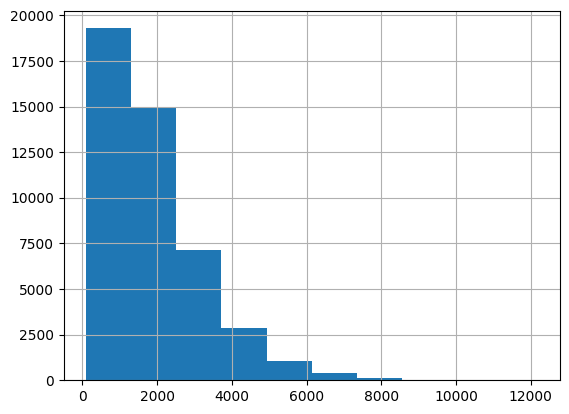

In [8]:
df.spent.hist();

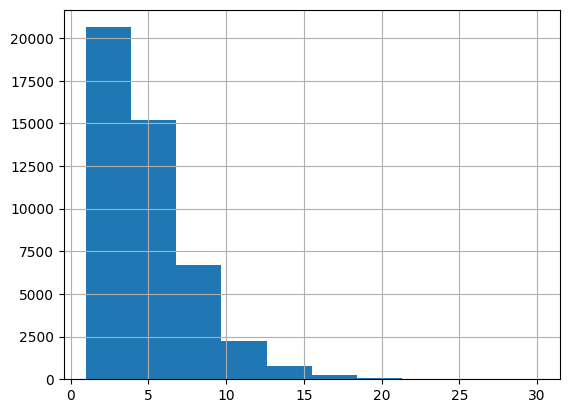

In [9]:
df.purchases.hist();

<Axes: >

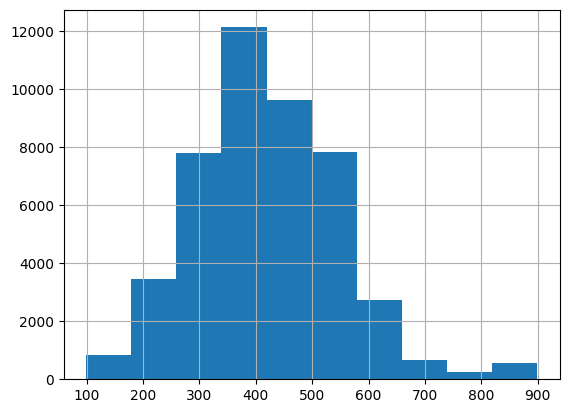

In [10]:
df.aov.hist()

Метрики скошены, поэтому будем применять бутстрап

## Bootstrap

$H_0$: metric(control) = metric(experiment)\
$H_1$: metric(control) ≠ metric(experiment)

In [11]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрап-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    from scipy.stats import zscore, norm
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2))

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация

    plt.hist(pd_boot_data[0], bins = 50)


    plt.vlines(ci,ymin=0,ymax=100,linestyle='--', colors='red')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

In [12]:
#spent
sample1 = df[df['group'] == 'control'].spent
sample2 = df[df['group'] == 'variant'].spent

  0%|          | 0/5000 [00:00<?, ?it/s]

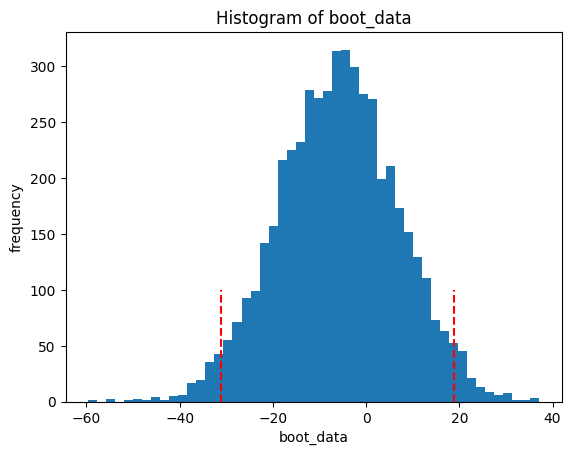

In [13]:
booted_data = get_bootstrap(sample1, sample2, boot_it = 5000, statistic=np.mean)

0 входит в доверительный интервал, поэтому мы не можем отвернуть нулевую гипотезу

In [14]:
#aov
sample1 = df[df['group'] == 'control'].aov
sample2 = df[df['group'] == 'variant'].aov

  0%|          | 0/5000 [00:00<?, ?it/s]

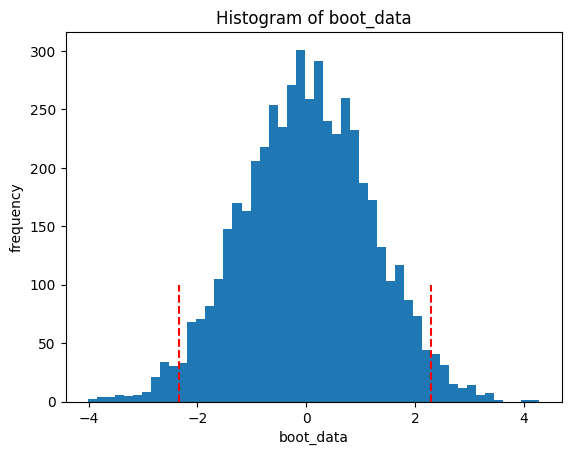

In [15]:
booted_data = get_bootstrap(sample1, sample2, boot_it = 5000, statistic=np.mean)

0 входит в доверительный интервал, поэтому мы не можем отвернуть нулевую гипотезу

In [16]:
#spent
sample1 = df[df['group'] == 'control'].purchases
sample2 = df[df['group'] == 'variant'].purchases

  0%|          | 0/5000 [00:00<?, ?it/s]

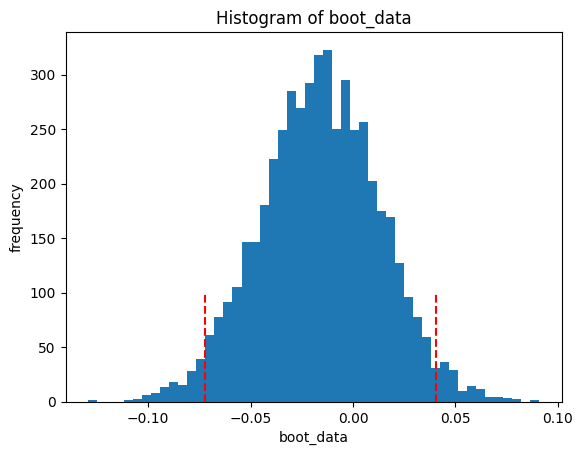

In [17]:
booted_data = get_bootstrap(sample1, sample2, boot_it = 5000, statistic=np.mean)

0 входит в доверительный интервал, поэтому мы не можем отвернуть нулевую гипотезу

Мы не можем отклонить нулевую гипотезу для метрик
# Оставляем контрольную версию